# Modèle Black-Scholes et simulation de Monte Carlo


Les options sont des dérivés financiers basés sur la valeur des titres sous-jacents. Ils donnent à l'acheteur le droit d'acheter (options d'achat) ou de vendre (options de vente) l'actif sous-jacent à un prix prédéterminé dans un délai précis. Il existe également deux styles d'options de base : américain et européen. Les options américaines peuvent être exercées à tout moment avant la date d'expiration de l'option, tandis que les options européennes ne peuvent être exercées qu'à la date d'expiration. Ce Notebook plonge dans un modèle d'évaluation des options pour comprendre l'évaluation des options européennes.

## Monte Carlo

### Definition

La méthode de Monte-Carlo (du nom des casinos, pas d'une personne) est une approche probabiliste permettant d'approximer la valeur d'une intégrale. L'idée de base est que l'intégrale $G$ peut être vue comme l'espérance d'une variable aléatoire uniforme $X$ sur l'intervalle $[a,b]$:

$$
{
     
    G=\mathbb {E} (g(X))=\int_a^b g(x) dx
}
$$

L'idée est de produire un échantillon $(x_1 ,x_2,...,x_N)$ de la variable aléatoire $X$, et de calculer un estimateur de $G$ dit de Monte-Carlo, à partir de cet échantillon.
La loi des grands nombres suggère de construire cet estimateur à partir de la moyenne empirique:
$$
{     
    {\bar {g}}_{N}={\frac {1}{N}}\sum _{i=1}^{N}g(x_{i}),
}
$$
Ceci est *l'estimateur de Monte-Carlo*. 

Cette estimation est sans biais, dans le sens où
$$
{
     \mathbb {E} ({\bar {g}}_{N})=G=\mathbb {E} (g(X))=\int_{a}^{b} g(x) dx
}
$$


In [1]:
from numpy.random import uniform
from numpy import array
from scipy.stats import norm
from numpy import log,sin,pi,sqrt,exp,maximum
from numpy.random import seed 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def MonteCarlo(g,N,a=0,b=1):
    x = a + (b-a)*uniform(size=N)
    g_N=1/N * g(x).sum()
    sigma_g = g(x).std()
    return g_N,sigma_g

>Example : Aprroximation de $\pi$

pour approximer $\pi$ on va utiliser la fonction suivant: $\forall x \in \mathbb{R}$
$$
    f(x)=\frac{4}{1+x^2}
$$
On a 
$$
\begin{aligned}
 \int_0^1 f(x)dx &= \pi
 \end{aligned}
$$

In [3]:
def f(x):return 4/(1+x**2)

In [4]:
N=10000000
print(f"Approximation de π par Monte Carlo pour un échantillon de {N}: {MonteCarlo(f,N)[0]} ± {MonteCarlo(f,N)[1]:.3}")

Approximation de π par Monte Carlo pour un échantillon de 10000000: 3.1416821955149716 ± 0.643



Il faut aussi quantifier la précision de cette estimation, via la variance de $\bar {g}_{N}$ qui s'exprime à l'aide de la variance de ${ g(X)}$.
$$
{
    \sigma _{g}^{2}:=\sigma _{g(X)}^{2}=\mathbb {E} ([g(X)-\mathbb {E} (g(X))]^{2})=\mathbb {E} (g^{2}(X))-\mathbb {E} ^{2}(g(X))=\int g^{2}(x)f_{X}(x)\,{d}x-G^{2}
}
$$
Si l'échantillon est supposé iid, cette dernière est estimée à l'aide de sa variance empirique
$$
{ S_{g(X)}^{2}={\frac {1}{N}}\sum _{i=1}^{N}(g(x_{i})-{\bar {g}}_{N})^{2}={\frac {1}{N}}\sum _{i=1}^{N}g^{2}(x_{i})-{\bar {g}}_{N}^{2}\simeq \sigma _{g}^{2}}
$$

L'erreur d'approximation moyenne est contrôlée par le théorème de la limite centrale. On retiendra la règle heuristique  que pour M grand,  avec probabilité 95%, on a
$$

\mathbb {E} (g(X)) \in  [ \ \bar {g}_{N}- 1.96\cdot \frac{\sigma _{g}}{\sqrt{N}} ,  \bar {g}_{N}+ 1.96\cdot \frac{\sigma _{g}}{\sqrt{N}}] \

$$

>Example : Améluration de l'prroximation de $\pi$

on définit une fonction qui permet de faire de la statistique sur `k` évaluations de `montecarlo(g,N,a,b)` en retournant la moyenne des valeurs de `g_N` trouvées ainsi que la variance :

In [5]:
def StatMonteCarlo(g,N,k,a=0,b=1):
    # liste de nb résultats de Monte-Carlo
    liste= np.zeros(k)
    for i in range(k):
        liste[i],_ = MonteCarlo(g,N,a=a,b=b)
    return liste.mean(), liste.std()

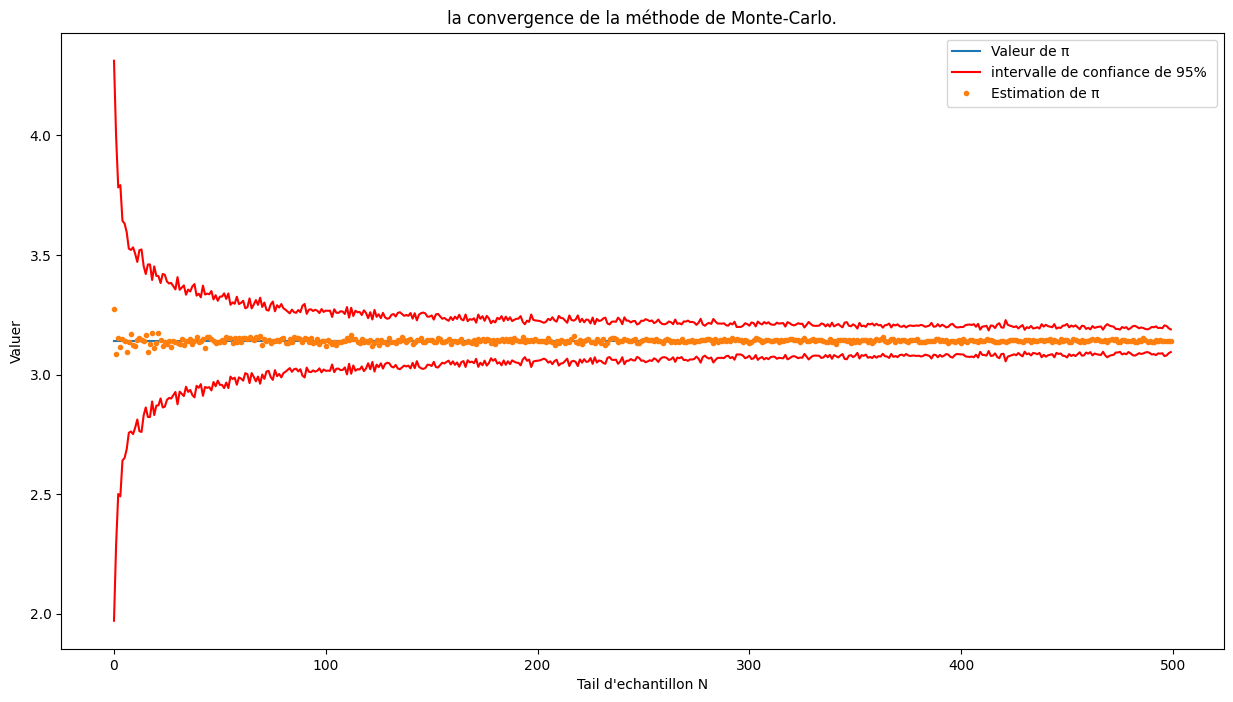

In [6]:
Nmax=500
k=50
# liste des valeurs de N
N = range(1,Nmax+1)
#tableaux pour la moyenne et la variance
mean=np.zeros(len(N))
std = np.zeros(len(N))
for i in range(len(N)):
    mean[i],std[i]= StatMonteCarlo(f,N[i],k)

plt.figure(figsize=(15,8))
Pi=plt.plot([np.pi]*Nmax)
Estimation=plt.plot(mean, ".")
plt.title('la convergence de la méthode de Monte-Carlo.')
plt.plot(np.pi+1.96*array(std), "r")
Interval=plt.plot(np.pi-1.96*array(std), "r")

plt.xlabel("Tail d'echantillon N")
plt.ylabel("Valuer")
plt.legend((Pi[0], Interval[0],Estimation[0]), ('Valeur de π', 'intervalle de confiance de 95% ','Estimation de π'))
plt.show()

L'implémentation précédente n'est en fait pas très intelligente, car pour chaque valeur $N$ de entre $1$ et $N_{max}$, de nouveaux nombres aléatoires sont générés et la fonction est évaluée sur ceux-ci. Une autre approche consiste à générer $N_{max}\times k$ valeurs aléatoires,à évaluer dessus, puis ensuite de prendre en compte seulement d'entre elles pourcalculer la dépendance en $N$. Les réalisations sur les différentes valeurs de $N$ ne sont évidemment plus indépendantes avec cette approche. De plus, il serait plus judicieux de calculer les statistiques:

In [7]:
def FastMonteCarlo(g):
    Nmax,k=g.shape
    g_N=g.cumsum(axis=0).mean(axis=1)/np.arange(1, Nmax+1) 
    sigma_g=g.std(axis=1)/sqrt(np.arange(1, Nmax+1))
    return g_N,sigma_g

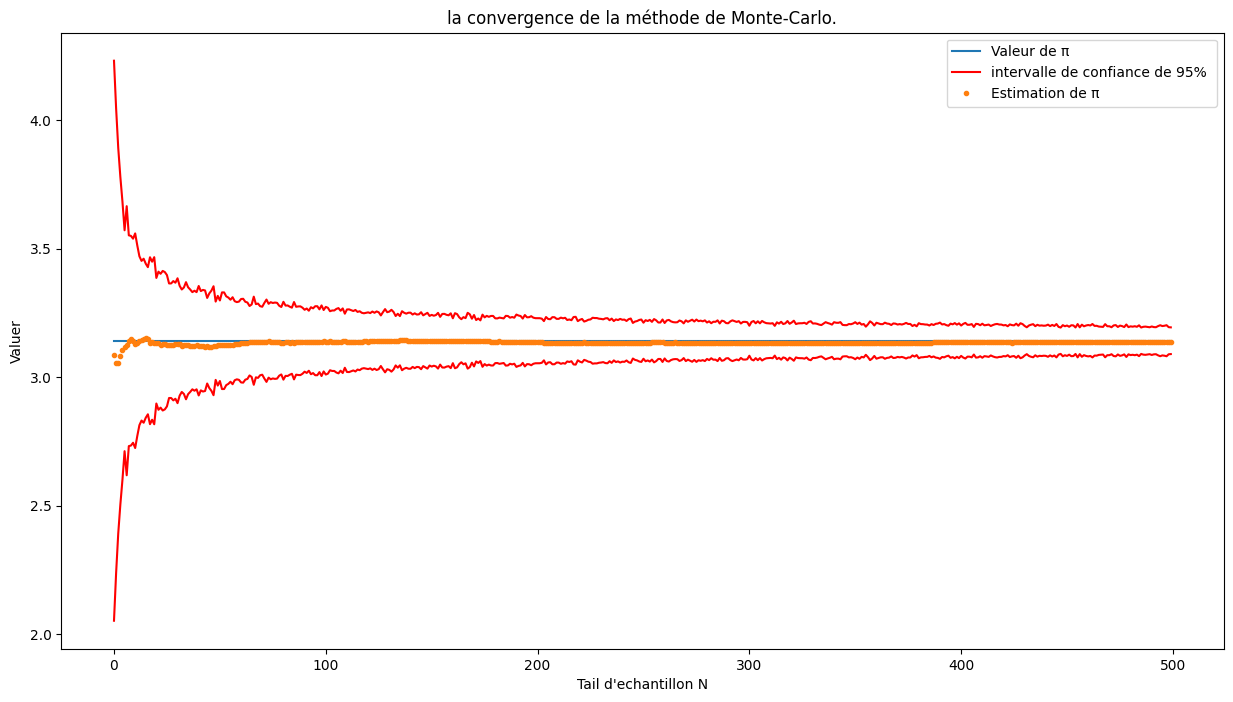

In [8]:
Nmax=500
k=50
U=uniform(size=(Nmax,k))
mean,std= FastMonteCarlo(f(U))

plt.figure(figsize=(15,8))
Pi=plt.plot([np.pi]*Nmax)
Estimation=plt.plot(mean, ".")
plt.title('la convergence de la méthode de Monte-Carlo.')
plt.plot(np.pi+1.96*array(std), "r")
Interval=plt.plot(np.pi-1.96*array(std), "r")

plt.xlabel("Tail d'echantillon N")
plt.ylabel("Valuer")
plt.legend((Pi[0], Interval[0],Estimation[0]), ('Valeur de π', 'intervalle de confiance de 95% ','Estimation de π'))
plt.show()

## Modèle Black-Scholes

### Modélisation du titre sous-jacent

Le modèle de Black-Scholes-Samuelson fournit une équation différentielle stochastique qui modélise les variations du cours d'une action donnée au fil du temps.

#### Hypothèses du modèle


Ces hypothèses sont irréalistes mais nécessaires pour le modèle.

- Il existe un taux constant $r$, continuellement composé et sans risque.
- Il n'y a pas de risque de défaut, pas de frais de transaction, pas de spreads, pas d'impôts et pas de dividendes
- Les marchés sont parfaitement liquides avec des ventes à découvert illimitées autorisées
- Aucun arbitrage n'est possible
- 
Le sous-jacent $S$ suit donc un mouvement brownien géométrique, qui satisfait l'équation différentielle stochastique:
$$
{
        \begin{aligned}
            dS_t&=r S_tdt+σS_tdB_t
        \end{aligned}
        }
$$

où $r$ représente rendement instantané (tendance) de sous-jacent $S$, et $B$ est un mouvement Brownien.La solution analytique de l'EDS peut être résolue comme suit (lemme d'Ito) :
$$
{
        \begin{aligned}
            S_T &=  S_{0}e^{(r - \sigma^2/2)T+\sigma \sqrt{T} Z}
        \end{aligned}
        }
$$
où $Z$ est une variable aléatoire normale centrée réduite.

Or d'aprés le cours on a si $U_1$ et $U_2$ de variable aléatoire independant qui suite la loi $U_{[0,1]}$ Donc 
$$Z=\sqrt{-2 \cdot \log(U_1)}\cdot\sin(2\cdot\pi\cdot U_2)\sim N(0,1)$$

#### Simulation de l'actif sous-jacent $S$ Vectorisé

In [9]:
def Normal(Nmax,k=1):
    """
    Returns a standard normal random variable.
    """
    U1=uniform(0,1,size=(Nmax,k))
    U2=uniform(0,1,size=(Nmax,k))
    return sqrt(-2*log(U1))*sin(2*pi*U2)
Z=Normal(100000)

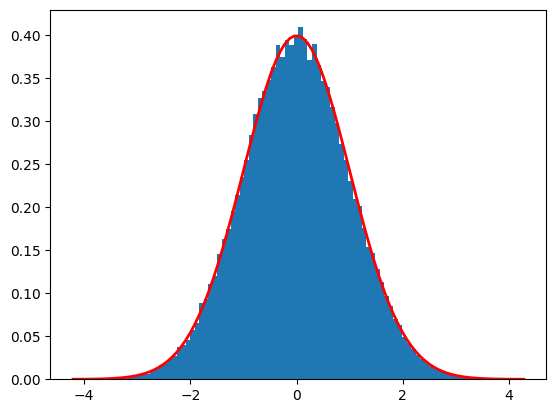

In [10]:
count, bins, ignored = plt.hist(Z, 100, density=True)
plt.plot(bins, 1/(sqrt(2 * pi))*exp( - (bins)**2 / 2 ),linewidth=2, color='r')
plt.show()

Nous pouvons voir une distribution de forme normale habituel.

In [11]:
def Stock_Price(S_0,r,sigma,t):
    return  S_0*exp((r - sigma**2/2)*t+sigma*sqrt(t)* Z)

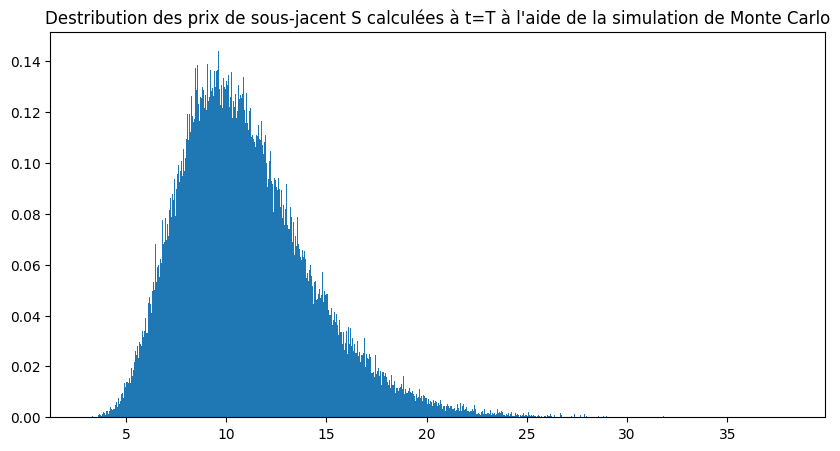

In [12]:
S_0=10
r=0.1
sigma=0.3
T=1         # Maturité de 1 an
S_T=Stock_Price(S_0,r,sigma,T)
plt.figure(figsize=(10,5))
plt.title("Destribution des prix de sous-jacent S calculées à t=T à l'aide de la simulation de Monte Carlo")
plt.hist(S_T, 1000, density=True)
plt.show()

### Solution analytique
Le modèle Black-Scholes est un modèle mathématique de valorisation d'un contrat d'options. Le modèle est basé sur le mouvement brownien géométrique (GBM) avec une tendance et une volatilité constantes. L'équation de Black-Scholes est une équation aux dérivées partielles du second ordre, qui donne une estimation théorique du prix des options européennes dans le temps:

$${\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0$$
où $S(t)$ est le prix de l'actif sous-jacent à l'instant $t$ ; $V(S,t)$ est le prix de l'option en fonction du sous-jacent $S$, à l'instant $t$ ; r est le taux d'intérêt sans risque ; $\sigma$ est la volatilité des rendements de l'actif sous-jacent ; $t$ est l'heure actuelle en années.
en résolvant l'équation des conditions terminales et aux limites correspondantes :

${\begin{aligned}&C(0,t)=0 ,{\forall} t
\\&C(S,t)\rightarrow S-K{\text{ quand }}S\rightarrow \infty 
\\&C(S,T)=\max\{S-K,0\}\end{aligned}}$

La valeur d'une **option d'achat** (Call) pour une sous-jacente sans dividendes en termes de paramètres Black-Scholes est :

$$
{   
    {
        \begin{aligned}
            C(S_{t},t)  &=  F_{X}(d_{1})S_{t}-F_{X}(d_{2})Ke^{-r(T-t)}
            \\{\text{avec}}
            \\d_{1}     &=  {\frac{1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac{S_{t}}{K}}\right)+\left(r+{\frac{\sigma^{2}}{2}}\right)(T-t)\right]
            \\d_{2}     &=  d_{1}-\sigma {\sqrt {T-t}}
        \end{aligned}
        }
}
$$

Le prix d'une **option de vente** correspondante avec un facteur de remise $e^{{-r(T-t)}}$ est :

$${
        \begin{aligned}
            P(S_{t},t)  &=  Ke^{-r(T-t)}-S_{t}+C(S_{t},t)
            \\          &=  F_{X}(-d_{2})Ke^{-r(T-t)}-F_{X}(-d_{1})S_{t}
        \end{aligned}}
$$
où $K$ est le prix d'exercice (Strike), $F_{X}$ est la fonction de répartition de $X \sim N(0,1)$, $T$ est l'échéance et $\tau=T-t$ est le temps jusqu'à l'échéance en années.

Donc Quand $t=0$ on a:

$${
        \begin{aligned}
            C(S_{0},0)  &=  F_{X}(d_{1})S_{0}-F_{X}(d_{2})Ke^{-rT}
                \\P(S_{0},0)  &=  F_{X}(-d_{2})Ke^{-rT}-F_{X}(-d_{1})S_{0}
            \\{\text{avec}}
            \\d_{1}     &=  {\frac{1}{\sigma {\sqrt {T}}}}[\ln ({\frac{S_{0}}{K}})+(r+{\frac{\sigma^{2}}{2}})T]
            \\d_{2}     &=  d_{1}-\sigma {\sqrt {T}}
        \end{aligned}}
$$


In [13]:
def OptionPrice(*,Type,S_0,K,r,sigma,tau):
    d_1 = (log(S_0/K) + (r + sigma**2/2)*tau)/(sigma*sqrt(tau))
    d_2 = d_1 - sigma*sqrt(tau)
    if Type.lower()=='call':
        analytic_price = S_0*norm.cdf(d_1) - K*exp(-r*tau)*norm.cdf(d_2)
    elif Type.lower()=='put':
        analytic_price = -S_0*norm.cdf(-d_1) + K*exp(-r*tau)*norm.cdf(-d_2)
    else:
        print('Option type is missing.')
    return analytic_price

## Simulation des options

### Call/Put option simulation

Nous fixerons le prix d'une option d'achat européenne vanille dans cette section. A ce titre nous avons besoin des informations suivantes :
- Taux d'intérêt sans risque composé en continu, $r$
- Volatilité des actions, $\sigma$
- Cours initial de sous-jacente, $S_0$
- Prix d'exercice de l'option, $K$
- Échéance de l'option, $T$
  
Supposons Donc que:

- Le taux sans risque est de 10%
- La volatilité des actions est de 30 %
- Le prix actuel de l'action est de $100
- Le prix d'exercice sur l'option d'achat européenne est de $110
- La durée du contrat est de 12 mois

In [14]:
seed(0)
r=0.1
sigma=0.3
S_0=100
K=110
T=12/12        # Maturité
Nmax=10000
k=100
Z=Z=Normal(Nmax,k)
S_T=Stock_Price(S_0,r,sigma,T)

#### Le Payoff de l'option d'achat

Le Payoff de l'option d'achat est donné par :
$$ {
        \begin{aligned}
            (S_T - K)^+ &=\max(S_T - K,0)
        \end{aligned}
        }
$$

c-à-d nous exerçons le droit d'acheter l'action à un prix égal au prix d'exercice, $K$, lorsque la valeur de l'action, $S$ est supérieure au prix d'exercice, sinon nous n'exerçons pas l'option.

Pour l'option européenne, l'acheteur choisit d'exercer l'option à la date d'échéance $T$, le vendeur est obligé de vendre l'action sous-jacente à l'acheteur au prix d'exercice $K$. Ainsi, le prix de l'option d'achat au temps $t = 0$ est:
$$
{
        \begin{aligned}
            C_0 &= E[e^{-rT}(S_T - K)^+]
        \end{aligned}
        }
$$



Étant donné que nous avons une espérance, nous pouvons utiliser les techniques de Monte Carlo pour évaluer cette option; notre function $g$ est donc
$$
{
        \begin{aligned}
            g_{call}(S_T) &= e^{-rT}(S_T - K)^+
        \end{aligned}
        }
$$

In [15]:
def g_call(S_T,K=K,r=r,T=T): return exp(-r*T)*maximum(S_T-K,0)

In [16]:
MC_call,sigma_call=FastMonteCarlo(g_call(S_T))

In [17]:
MC_call_price=MC_call[-1]
print(f" le prix de l'option d'achat au temps t = 0 par Methode de monte carlo est: ${MC_call_price:.5} ± {sigma_call[-1]:.2}")
analytic_callprice=OptionPrice(Type='call',S_0=S_0,K=K,r=r,sigma=sigma,tau=T)
print(f" le prix de l'option d'achat au temps t = 0 par Methode analytique est: ${analytic_callprice:.5}")

 le prix de l'option d'achat au temps t = 0 par Methode de monte carlo est: $12.118 ± 0.22
 le prix de l'option d'achat au temps t = 0 par Methode analytique est: $12.131


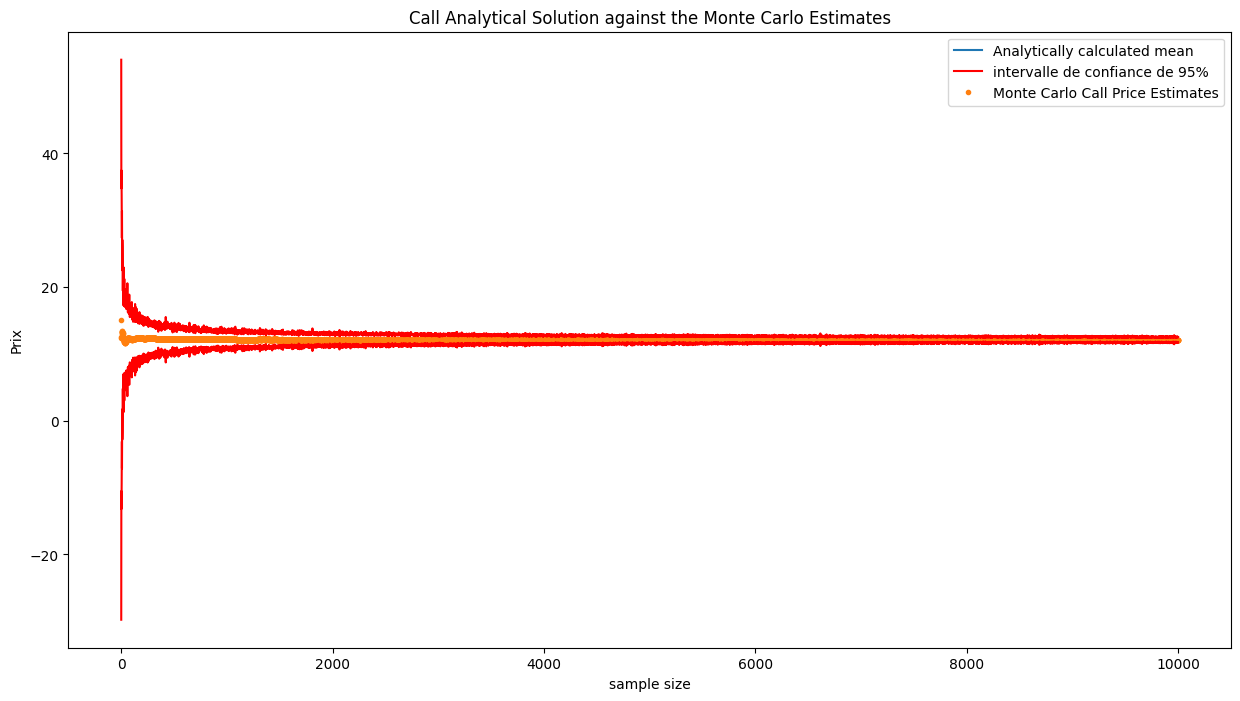

In [18]:
plt.figure(figsize=(15,8))
Analytical_mean=plt.plot([analytic_callprice]*Nmax)
CallPrice=plt.plot(MC_call, ".")
plt.title('Call Analytical Solution against the Monte Carlo Estimates')
plt.plot(analytic_callprice+1.96*array(sigma_call), "r")
Interval=plt.plot(analytic_callprice-1.96*array(sigma_call), "r")

plt.xlabel("sample size")
plt.ylabel("Prix")
plt.legend((Analytical_mean[0], Interval[0],CallPrice[0]), ('Analytically calculated mean', 'intervalle de confiance de 95% ','Monte Carlo Call Price Estimates'))
plt.show()

#### Le Payoff de l'option de vente

Le Payoff de l'option de vente est donné par :
$$ {
        \begin{aligned}
            (K - S_T)^+ &=\max(K - S_T,0)
        \end{aligned}
        }
$$

c-à-d nous exerçons le droit d'acheter l'action à un prix égal au prix d'exercice, $K$, lorsque la valeur de l'action, $S$ est supérieure au prix d'exercice, sinon nous n'exerçons pas l'option.

Pour l'option européenne, l'acheteur choisit d'exercer l'option à la date d'échéance $T$, le vendeur est obligé de achete le sous-jacente à l'acheteur au prix d'exercice $K$. Ainsi, le prix de l'option d'achat au temps $t = 0$ est:
$$
{
        \begin{aligned}
            P_0 &= E[e^{-rT}(K - S_T)^+]
        \end{aligned}
        }
$$

Étant donné que nous avons une espérance, nous pouvons utiliser les techniques de Monte Carlo pour évaluer cette option; notre function $g$ est donc
$$
{
        \begin{aligned}
            g_{put}(S_T) &= e^{-rT}(K - S_T)^+
        \end{aligned}
        }
$$

In [19]:
def g_put(S_T,K=K,r=r,T=T): return exp(-r*T)*maximum(K-S_T,0)

In [20]:
MC_put,sigma_put=FastMonteCarlo(g_put(S_T))

In [21]:
MC_put_price=MC_put[-1]
print(f" le prix de l'option de vente au temps t = 0 par Methode de monte carlo est: ${MC_put_price:.5} ± {sigma_put[-1]:.2}")
analytic_putprice=OptionPrice(Type='put',S_0=S_0,K=K,r=r,sigma=sigma,tau=T)
print(f" le prix de l'option de vente au temps t = 0 par Methode analytique est: ${analytic_putprice:.7}")

 le prix de l'option de vente au temps t = 0 par Methode de monte carlo est: $11.668 ± 0.15
 le prix de l'option de vente au temps t = 0 par Methode analytique est: $11.66314


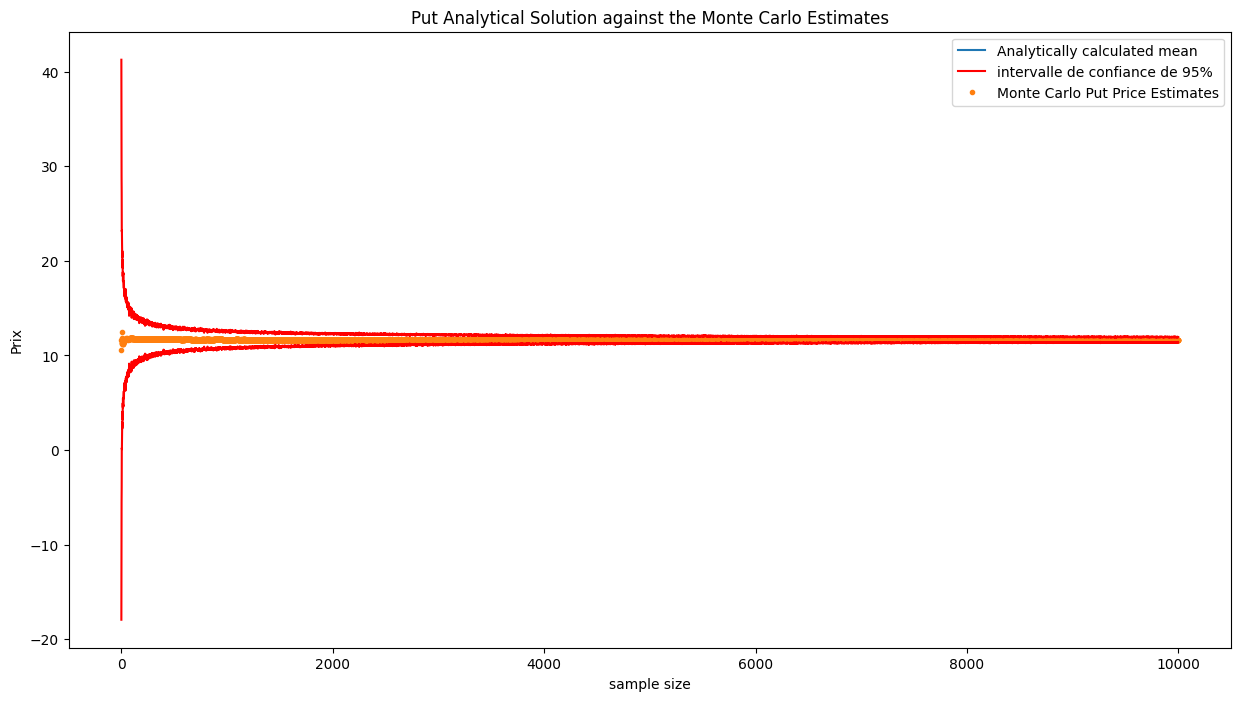

In [22]:
plt.figure(figsize=(15,8))
Analytical_mean=plt.plot([analytic_putprice]*Nmax)
CallPrice=plt.plot(MC_put, ".")
plt.title('Put Analytical Solution against the Monte Carlo Estimates')
plt.plot(analytic_putprice+1.96*array(sigma_put), "r")
Interval=plt.plot(analytic_putprice-1.96*array(sigma_put), "r")

plt.xlabel("sample size")
plt.ylabel("Prix")
plt.legend((Analytical_mean[0], Interval[0],CallPrice[0]), ('Analytically calculated mean', 'intervalle de confiance de 95% ','Monte Carlo Put Price Estimates'))
plt.show()